# Detecting COVID-19 using X-ray and Deep Learning using DenseNet-121

Authors: Vinayak Jaiwant, Akhil Kokani

Guide: Prof. Raghavendra Patil

Using Custom Dataset - 

Pneumonia Dataset from Paul Mooney https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

COVID Chest X-ray Dataset from ieee8023 https://github.com/ieee8023/covid-chestxray-dataset 
```
The structure of the dataset is as follows:
+---test
|   +---covid (100 items)
|   +---normal (234 items)
|   \---pneumonia (390 items)
\---train
    +---covid (396 items)
    +---normal (1341 items)
    \---pneumonia (3875 items)
```    

# Importing Libraries

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import torch.nn as nn
from torch import optim
import numpy as np
import shutil
import random
import torch
import os
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Preparing the Dataset

In [3]:
class_names = ['normal', 'pneumonia', 'covid']
root_dir    = 'core-dataset'
source_dirs = ['NORMAL', 'PNEUMONIA', 'COVID']

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): # Take all images regardless of the format
            images = [x for x in os.listdir(image_dirs[class_name]) if (x.lower().endswith('jpeg') or x.lower().endswith('jpg') or x.lower().endswith('png'))] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'pneumonia', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'core-dataset/normal',
    'pneumonia': 'core-dataset/pneumonia',
    'covid': 'core-dataset/covid'
}

In [8]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1341 normal examples
Found 3875 pneumonia examples
Found 396 covid examples


In [9]:
test_dirs = {
    'normal': 'core-dataset/test/normal',
    'pneumonia': 'core-dataset/test/pneumonia',
    'covid': 'core-dataset/test/covid'
}

In [10]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 234 normal examples
Found 390 pneumonia examples
Found 100 covid examples


In [11]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 936
Number of test batches 121


In [12]:
for data,label in dl_train:
    print(data.size())
    print(label.size())
    break

torch.Size([6, 3, 224, 224])
torch.Size([6])


# Visualising the dataset

In [13]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].cpu().numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

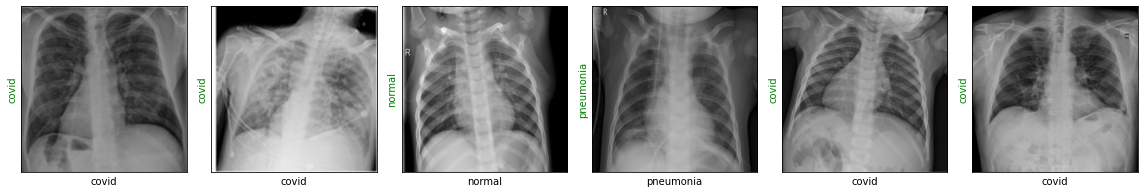

In [14]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

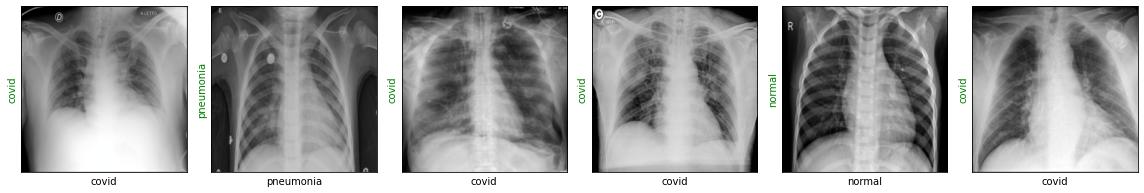

In [15]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Preparing the pretrained DenseNet-121 model

In [16]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

In [17]:
model = DenseNet121(num_classes=3).to(device)

## Configuring DenseNet-121 for training

In [18]:
LEARNING_RATE = 3e-5
LEARNING_RATE_SCHEDULE_FACTOR = 0.01
LEARNING_RATE_SCHEDULE_PATIENCE = 5
# Loss function
loss_criteria = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

## Displaying the model structure

In [19]:
print(model)

DenseNet121(
  (net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1

## Prediction function

In [20]:
def show_predictions():
    model.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs  = model(images)
    print(outputs)
    _, preds = torch.max(outputs, 1)
    print(preds)
    show_images(images, labels, preds)

# Training and Testing the Model

In [21]:
train_loss_arr=[]
val_loss_arr=[]
accuracy_arr=[]
def train(epochs):
    print('Training ...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        model.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 10 == 0:
                accuracy = 0
                model.eval() # set model to eval phase
                for val_step, (images, labels) in enumerate(dl_test):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = loss_criteria(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())

                val_loss /= (val_step + 1)
                accuracy = 100 * accuracy/len(test_dataset)
                train_loss /= (train_step + 1)
                val_loss_arr.append(val_loss*100)
                accuracy_arr.append(accuracy)
                train_loss_arr.append(train_loss*100)
                print('==========================================================================================')
                print(f'Step: {train_step}/{len(dl_train)}')
                print(f'Training Loss: {train_loss:.4f}                           Validation Loss: {val_loss:.4f}')
                print(f'Accuracy: {accuracy:.4f}')                
                #show_preds()
                model.train()
                if accuracy >= 95.00:
                    print('Performance Condition Reached')
                    return
                  
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')
    if torch.cuda.is_available(): torch.cuda.empty_cache()

#### Training for 1 epoch(s)

In [22]:
%%time

train(epochs=1)

Training ...
Epoch 1/1


/home/vjaiwantx/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Step: 0/936
Training Loss: 1.1148                           Validation Loss: 1.0977
Accuracy: 34.3923
Step: 10/936
Training Loss: 1.0744                           Validation Loss: 1.0670
Accuracy: 63.1215
Step: 20/936
Training Loss: 0.5459                           Validation Loss: 1.0231
Accuracy: 76.3812
Step: 30/936
Training Loss: 0.3343                           Validation Loss: 0.9881
Accuracy: 80.2486
Step: 40/936
Training Loss: 0.2388                           Validation Loss: 0.9395
Accuracy: 87.0166
Step: 50/936
Training Loss: 0.1836                           Validation Loss: 0.8961
Accuracy: 85.0829
Step: 60/936
Training Loss: 0.1474                           Validation Loss: 0.8658
Accuracy: 85.7735
Step: 70/936
Training Loss: 0.1234                           Validation Loss: 0.8409
Accuracy: 90.1934
Step: 80/936
Training Loss: 0.1057                           Validation Loss: 0.8144
Accuracy: 89.2265
Step: 90/936
Training Loss: 0.0901                           Validation Lo

Step: 430/936
Training Loss: 0.0146                           Validation Loss: 0.6648
Accuracy: 90.1934
Step: 440/936
Training Loss: 0.0157                           Validation Loss: 0.6797
Accuracy: 88.3978
Step: 450/936
Training Loss: 0.0143                           Validation Loss: 0.7115
Accuracy: 83.1492
Step: 460/936
Training Loss: 0.0142                           Validation Loss: 0.6854
Accuracy: 85.9116
Step: 470/936
Training Loss: 0.0139                           Validation Loss: 0.6684
Accuracy: 89.6409
Step: 480/936
Training Loss: 0.0139                           Validation Loss: 0.6797
Accuracy: 88.3978
Step: 490/936
Training Loss: 0.0140                           Validation Loss: 0.6984
Accuracy: 84.9448
Step: 500/936
Training Loss: 0.0134                           Validation Loss: 0.6591
Accuracy: 89.5028
Step: 510/936
Training Loss: 0.0131                           Validation Loss: 0.6743
Accuracy: 87.7072
Step: 520/936
Training Loss: 0.0125                           Va

Step: 860/936
Training Loss: 0.0071                           Validation Loss: 0.6920
Accuracy: 87.2928
Step: 870/936
Training Loss: 0.0074                           Validation Loss: 0.6723
Accuracy: 88.6740
Step: 880/936
Training Loss: 0.0069                           Validation Loss: 0.6515
Accuracy: 90.8840
Step: 890/936
Training Loss: 0.0069                           Validation Loss: 0.7034
Accuracy: 84.5304
Step: 900/936
Training Loss: 0.0070                           Validation Loss: 0.7555
Accuracy: 76.7956
Step: 910/936
Training Loss: 0.0070                           Validation Loss: 0.6871
Accuracy: 87.4309
Step: 920/936
Training Loss: 0.0065                           Validation Loss: 0.6488
Accuracy: 91.4365
Step: 930/936
Training Loss: 0.0063                           Validation Loss: 0.6595
Accuracy: 89.9171
Training Loss: 3.5212
Training complete..
CPU times: user 1h 49min 40s, sys: 51min 1s, total: 2h 40min 41s
Wall time: 41min 4s


# Predictions

tensor([[6.3892e-03, 9.9982e-01, 1.5409e-04],
        [9.4899e-01, 7.6383e-01, 3.0076e-04],
        [9.9854e-01, 3.1179e-02, 3.4436e-04],
        [9.9812e-01, 6.1467e-02, 3.2180e-04],
        [9.4289e-01, 9.3784e-01, 1.3977e-04],
        [4.5192e-03, 5.9510e-02, 9.8480e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([1, 0, 0, 0, 0, 2], device='cuda:0')


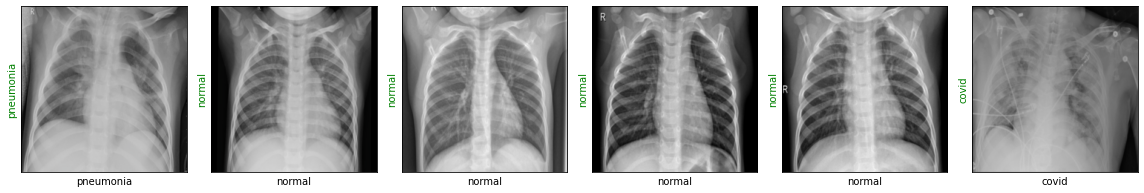

In [23]:
show_predictions()

## Graph Plot

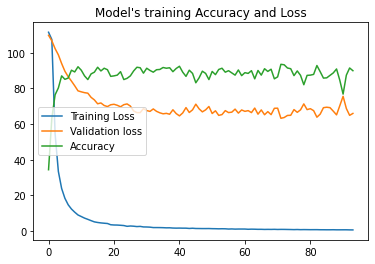

In [24]:
plt.plot(train_loss_arr,label="Training Loss")
plt.plot(val_loss_arr,label="Validation loss")
plt.plot(accuracy_arr,label="Accuracy")
plt.title("Model's training Accuracy and Loss")
plt.legend()

## Confusion Matrix

<AxesSubplot:>

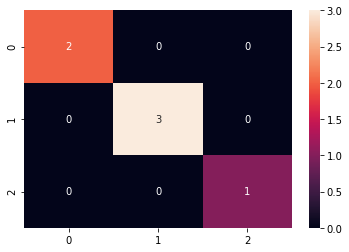

In [25]:
images, labels = next(iter(dl_test))
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_,preds = torch.max(outputs,1)
y_true = labels.cpu().numpy()
y_pred = preds.cpu().numpy()
cf_matrix = confusion_matrix(y_true,y_pred)
score = f1_score(y_true,y_pred,average='macro')
sns.heatmap(cf_matrix, annot=True)

## F1 Score and Accuracy

In [26]:
print("Accuracy:",accuracy_arr[-1],"%")
print(f'F1 Score: {score}')

Accuracy: 89.9171270718232 %
F1 Score: 1.0


## Saving the model for inference

In [27]:
torch.save(model.state_dict(),"model2-densenet121.pth")